In [2]:
#Installing required libraries
!pip install hickle

     |████████████████████████████████| 40kB 2.1MB/s 


In [3]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import os
import random
import hickle as h
import pickle as p
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import keras.backend as K
from tensorflow.keras.models import model_from_json

Using TensorFlow backend.


In [0]:
#Function for padding mfcc
def padding(egs):
    max_val = max([e.shape[0] for e in egs])
    padded = np.array([np.pad(e, ((0, max_val-e.shape[0]), (0, 0)) , 'constant') for e in egs])
    return padded  

In [6]:
#Loading data from drive
mfccs = h.load('drive/My Drive/mfcc.hkl')
deltas = h.load('drive/My Drive/deltas.hkl')
ddeltas = h.load('drive/My Drive/ddeltas.hkl')

#Removing any nan values
mfccs = [np.nan_to_num(m.T) for m in mfccs]
deltas = [np.nan_to_num(d.T) for d in deltas]
ddeltas = [np.nan_to_num(dd.T) for dd in ddeltas]

#Normalizing the values
mfccs = [m/np.max(m) for m in mfccs]
deltas = [d/np.max(d) for d in deltas]
ddeltas = [dd/np.max(dd) for dd in ddeltas]

#Padding the vectors
mfccs = padding(mfccs)
deltas = padding(deltas)
ddeltas = padding(ddeltas)

#Stacking the data
data = np.array([[i,j,k] for i, j, k in zip(mfccs, deltas, ddeltas)])
data = data.reshape(2432, 5388, 20, 3)
del(mfccs)
del(deltas)
del(ddeltas)
print(data.shape)


(2432, 5388, 20, 3)


In [0]:
#Creating similar and dissimilar datasets for Siamese Model
def createDataset(clientID2Index, name):
  similar_dataset = []
  for i in clientID2Index:
    for j in clientID2Index[i]:
      for k in clientID2Index[i]:
        inp1, inp2 = j,k
        similar_dataset.append((inp1, inp2, 1))
  
  dissimilar_dataset = []
  for i in clientID2Index:
    other_speakers = [x for x in clientID2Index.keys() if i!=x]
    for j in other_speakers:
      for x in clientID2Index[i]:
        for y in clientID2Index[j]:
          inp1, inp2 = x,y
          dissimilar_dataset.append((inp1, inp2, -1))
  
  #Making both the labels balanced
  ind = [i for i in range(len(dissimilar_dataset))]
  indexes_to_have = random.sample(ind, len(similar_dataset))
  dissimilar_dataset = [dissimilar_dataset[i] for i in indexes_to_have]
  #Saving
  dataset = np.array(similar_dataset + dissimilar_dataset)
  #Shuffline dataset
  np.random.shuffle(dataset)
  print(dataset.shape)
  np.save('drive/My Drive/'+name+'.npy', dataset)

train = pd.read_csv('drive/My Drive/train.tsv', sep='\t')
#All speakers in my train data
num_speakers = len(set(train['client_id']))
spk = list(set(train['client_id']))
mapped = {spk[i]:i for i in range(num_speakers)}
train = train.replace(mapped)

#The following dictionary stores a mapping of speakerID to indexes of examples
clientID2Index = {i:[] for i in range(28)}
for i, val in enumerate(train['client_id']):
  clientID2Index[val].append(i)

#Creating dataset to train Siamese Model
createDataset(clientID2Index, 'SiameseDataset')


(1014032, 3)


In [7]:
#Loading the data to train Siamese Model
dataset = np.load('drive/My Drive/SiameseDataset.npy')
dataset.shape

(1014032, 3)

In [8]:
train, trainy, val, valy, test, testy = dataset[:600000,:2], dataset[:600000,2], dataset[600000:650000,:2], dataset[600000:650000:,2], dataset[650000:,:2], dataset[650000:,2]
trainy = np.array([i if i==1 else 0 for i in trainy])
valy = np.array([i if i==1 else 0 for i in valy])
testy = np.array([i if i==1 else 0 for i in testy])
print(train.shape, val.shape, test.shape)

(600000, 2) (50000, 2) (364032, 2)


In [0]:
def train_network(train, ytrain, val, yval, test, ytest, data, batchsize, num_epochs, lr=0.001):
    #input_shape = (5388, 20, 3)
    #X1 = tf.placeholder('float32', [None, 5388, 20, 3], name = 'Inp1')
    #X2 = tf.placeholder('float32', [None, 5388, 20, 3], name = 'Inp2')
    
    X1 = tf.keras.Input(shape=(5388, 20, 3))
    X2 = tf.keras.Input(shape=(5388, 20, 3))
    y = tf.placeholder('int32',[None],name='t1')

    #Encoder 1
    #Convolution layer 1
    layer11 = layers.Conv2D(40, 5, activation='relu', name="L11")(X1)
    layer11 = layers.Dropout(0.05)(layer11)
    out11 = layers.MaxPooling2D(5)(layer11)
    #Convolution layer 2
    layer21 = layers.Conv2D(20, 2, activation='relu', name="L21")(out11)
    layer21 = layers.Dropout(0.05)(layer21)
    out21 = layers.MaxPooling2D(2)(layer21)
    #Convolution layer 3
    layer31 = layers.Conv2D(10, (2,1), activation='relu', name="L31")(out21)
    out31 = layers.Dropout(0.05)(layer31)
    #Flattened layer
    flatten1 = layers.Flatten()(out31)
    #Dense Layer
    embeds1 = layers.Dense(100, activation = "sigmoid", name="D11")(flatten1)

    #Encoder 2
    #Convolution layer 1
    layer12 = layers.Conv2D(40, 5, activation='relu', name="L12")(X2)
    layer12 = layers.Dropout(0.05)(layer12)
    out12 = layers.MaxPooling2D(5)(layer12)
    #Convolution layer 2
    layer22 = layers.Conv2D(20, 2, activation='relu', name="L22")(out12)
    layer22 = layers.Dropout(0.05)(layer22)
    out22 = layers.MaxPooling2D(2)(layer22)
    #Convolution layer 3
    layer32 = layers.Conv2D(10, (2,1), activation='relu', name="L32")(out22)
    out32 = layers.Dropout(0.05)(layer32)
    #Flattened layer
    flatten2 = layers.Flatten()(out32)
    #Dense Layer
    embeds2 = layers.Dense(100, activation = "sigmoid", name="D12")(flatten2)
  
    #Siamese network
    embedded_distance = layers.Subtract(name='subtract_embeddings')([embeds1, embeds2])
    embedded_distance1 = layers.Lambda(lambda x: tf.sqrt(tf.reduce_sum(tf.square(x), axis=-1, keepdims=True)), name='euclidean_distance')(embedded_distance)
    siamese_out = layers.Dense(2, activation='sigmoid', name="OutputLayer")(embedded_distance1)

    #Saving model for embeddings
    embeds = tf.keras.Model(inputs=[X1,X2], outputs = embedded_distance)
    siamesemodel = tf.keras.Model(inputs=[X1,X2], outputs = siamese_out)
    
    #Loss
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y,logits = siamese_out)
    loss = tf.reduce_mean(loss)
    
    #Optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
    soft_out = tf.nn.softmax(siamese_out)
    
    y_onehot = tf.one_hot(y, 2)
    #Prediction and accuracy
    pred = tf.equal(tf.argmax(soft_out,1), tf.argmax(y_onehot,1))
    accuracy = tf.reduce_mean(tf.cast(pred, tf.float32))
    
    #Saving history
    hist = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
    saver = tf.train.Saver()
    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())
      steps = train.shape[0]//batchsize
      print("Steps:", steps)
      for epoch in range(num_epochs):
          epoch_loss = 0
          epoch_acc = 0
          for step in range(2):
              start = step*batchsize
              end = min(start + batchsize, train.shape[0])
              batch_x = train[start:end]
              batch_data1 = np.array([data[i[0]] for i in batch_x])
              batch_data2 = np.array([data[i[1]] for i in batch_x])
              batchy = ytrain[start:end]
              #print(batch_data1.shape, batch_data2.shape, batchy.shape)
              _, cost = sess.run([optimizer, loss], feed_dict={X1:batch_data1, X2:batch_data2, y:batchy})
              train_acc = sess.run(accuracy, feed_dict = {X1:batch_data1, X2:batch_data2, y:batchy})
              epoch_loss += cost
              epoch_acc += train_acc
              if step%100 == 0:
                print("Epoch:",epoch,"Step:",step+1,"TrainLoss:",epoch_loss/(step+1), "accuracy:", epoch_acc/(step+1))
              saved_path = saver.sess(sess, "drive/My Drive/test.ckpt", global_step = step)
              hist['train_loss'].append(epoch_loss/(step+1))
              hist['train_acc'].append(epoch_acc/(step+1))
          print("Saved model to disk")
          print("Epoch:",epoch,"Loss:", epoch_loss/steps, "accuracy:", epoch_acc/steps)
          val_batches = val.shape[0]//batchsize
          val_l = 0
          val_a = 0
          for x in range(val_batches):
              start = x*batchsize
              end = min(start + batchsize, val.shape[0])
              valbatch_x = val[start:end]
              valbatch_data1 = np.array([data[i[0]] for i in valbatch_x])
              valbatch_data2 = np.array([data[i[1]] for i in valbatch_x]) 
              valbatchy = yval[start:end]
              val_loss, val_acc = sess.run([loss,accuracy], feed_dict = {X1:valbatch_data1,
                                                                          X2:valbatch_data2,
                                                                          y:valbatchy})
              val_l += val_loss
              val_a += val_acc
              hist['val_loss'].append(val_loss)
              hist['val_acc'].append(val_acc)
          print("Validation:","Epoch:",epoch,"Loss:", val_l/val_batches, "accuracy:", val_a/val_batches)
      test_batches = test.shape[0]//batchsize
      test_l = 0
      test_a = 0
      for x in range(test_batches):
          start = x*batchsize
          end = min(start + batchsize, test.shape[0])
          testbatch_x = test[start:end]
          testbatch_data1 = np.array([data[i[0]] for i in testbatch_x])
          testbatch_data2 = np.array([data[i[1]] for i in testbatch_x]) 
          testbatchy = ytest[start:end]
          test_loss, test_acc = sess.run([loss,accuracy], feed_dict = {X1:testbatch_data1,
                                                                      X2:testbatch_data2,
                                                                      y:testbatchy})
          test_l += test_loss
          test_a += test_acc
      print("Test: Loss:", test_l/test_batches, "accuracy:", test_a/test_batches)
          
    return (hist, siamesemodel, embeds)


In [0]:
#Checking shapes of data and training the model
print(train.shape, trainy.shape, val.shape, valy.shape, test.shape, testy.shape, data.shape)
model_hist, embeddingModel, embeds = train_network(train, trainy, val, valy, test, testy, data, batchsize = 128, num_epochs = 1)

The model is trained for 10 epochs. We load the trained models and their history.

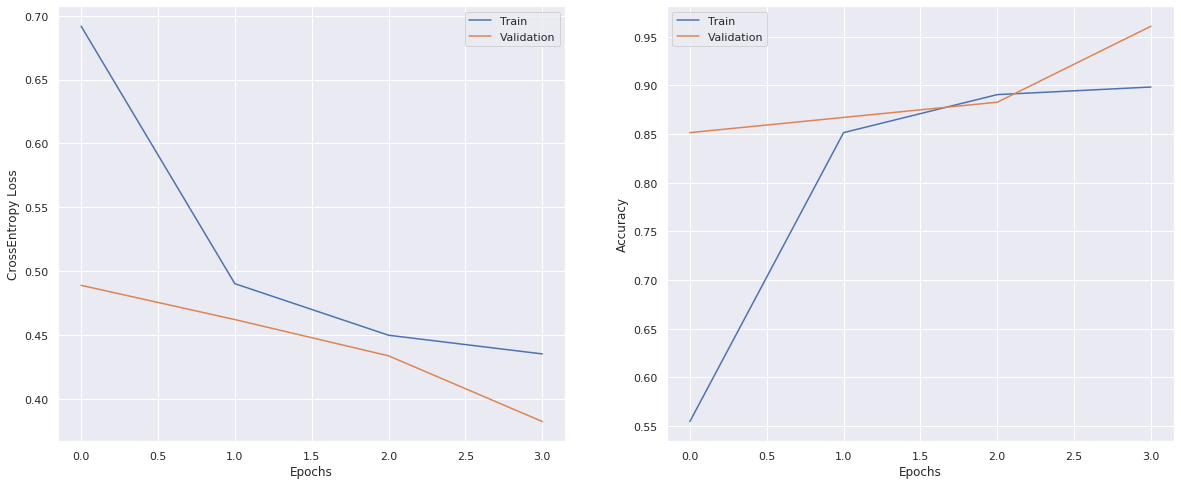

In [173]:
#Loading training history and models.
with open("drive/My Drive/Models/bestModelHistory.pkl", "rb") as f:
  history = p.load(f)
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (20,8))
ax1.plot(history['train_loss'][::4687])
ax1.plot(np.array(history['test_loss'][::39])*39)
ax1.legend(["Train", "Validation"])
ax1.set(xlabel = 'Epochs',ylabel="CrossEntropy Loss")
ax2.plot(history['train_acc'][::4687])
ax2.plot(np.array(history['test_acc'][::39])*39)
ax2.set(xlabel = 'Epochs', ylabel='Accuracy')
ax2.legend(["Train", "Validation"])
plt.savefig("drive/My Drive/lossfigs.png")

In [9]:
#Loading Siamese Model
json_file = open('drive/My Drive/Models/Smodel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
SiameseModel = model_from_json(loaded_model_json)
# load weights into new model
SiameseModel.load_weights("drive/My Drive/Models/Smodel.h5")

#Loading Embeddings Model
json_file = open('drive/My Drive/Models/embeds.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
embeddings = model_from_json(loaded_model_json)
# load weights into new model
embeddings.load_weights("drive/My Drive/Models/embeds.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [10]:
#Running on test data
test_batches = test.shape[0]//128
test_l = 0
test_a = 0
predictions = []
for x in tqdm_notebook(range(10)):
    start = x*128
    end = min(start + 128, test.shape[0])
    testbatch_x = val[start:end]
    testbatch_data1 = np.array([data[i[0]] for i in testbatch_x])
    testbatch_data2 = np.array([data[i[1]] for i in testbatch_x]) 
    preds = embeddings.predict([testbatch_data1, testbatch_data2])
    predictions.extend(preds)
predictions = np.array(predictions)

Text(0, 0.5, 'PCA_Axis 2')

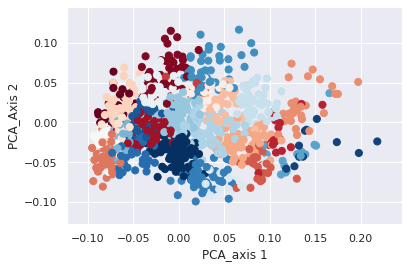

In [14]:
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
kmeans = KMeans(n_clusters=27, random_state=0).fit(predictions)
#spec = SpectralClustering(n_clusters=2).fit(predictions)
y_kmeans = kmeans.predict(predictions)
#y_spec = spec.fit_predict(predictions)
centers = kmeans.cluster_centers_

pca = PCA(.95)
pca.fit(predictions)
preds = pca.transform(predictions)

plt.scatter(preds[:, 0], preds[:, 1], c=y_kmeans, s=50, cmap='RdBu')
#plt.scatter(preds[:, 0], preds[:, 1], c=y_spec, s=50, cmap='RdBu')

plt.xlabel("PCA_axis 1")
plt.ylabel("PCA_Axis 2")
#plt.savefig('drive/My Drive/clustered_embeds.png')

In [0]:
weights = [layer.get_weights() for layer in embeddings.layers]

In [172]:
weights[-2][0].shape

(5360, 100)

In [22]:
conv1_filters = weights[2][0]
min_v, max_v = conv1_filters.min(), conv1_filters.max()
conv1_filters1 = (conv1_filters - min_v)/(max_v-min_v)
conv2_filters = weights[3][0]
min_v, max_v = conv2_filters.min(), conv2_filters.max()
conv2_filters1 = (conv2_filters - min_v)/(max_v-min_v)

print(conv1_filters1.shape, conv2_filters1.shape)

(5, 5, 3, 40) (5, 5, 3, 40)


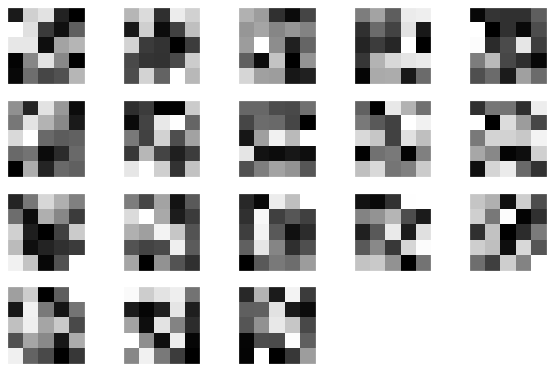

In [23]:
# plot first few filters
n_filters, ix = 6, 1
fig = plt.figure(figsize=(10,10))
for i in range(n_filters):
  # get the filter
  f = conv1_filters1[:, :, :, i]
  # plot each channel separately
  for j in range(3):
    # specify subplot and turn of axis
    ax = plt.subplot(n_filters, 5, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    plt.imshow(f[:, :, j], cmap='gray')
    ix += 1
# show the figure
plt.show()


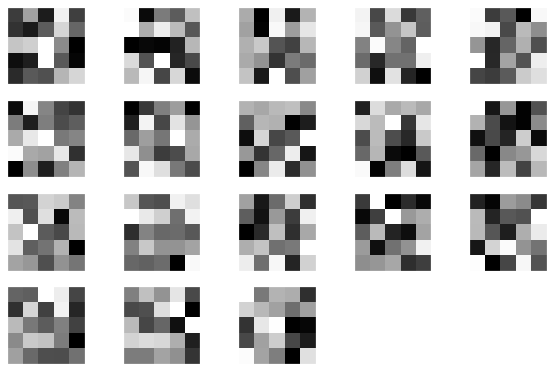

In [24]:
# plot first few filters
n_filters, ix = 6, 1
fig = plt.figure(figsize=(10,10))
for i in range(n_filters):
  # get the filter
  f = conv2_filters1[:, :, :, i]
  # plot each channel separately
  for j in range(3):
    # specify subplot and turn of axis
    ax = plt.subplot(n_filters, 5, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    plt.imshow(f[:, :, j], cmap='gray')
    ix += 1
# show the figure
plt.show()